## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:
- Python
- matplotlib
- The Python standard library
- Jupyter notebooks and nbdev

Once we implemented something correctly using only the above, we can then start using another library implementation.

In [2]:
from pathlib import Path
#import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get data

In [3]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

[urlretrieve](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve) - (read the docs!)

In [4]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [5]:
ls -l data

total 33312
drwxr-xr-x  7 germangoldszmidt  staff       224 Dec 27 15:49 image_fashion_mnist/
-rw-r--r--  1 germangoldszmidt  staff  17051982 Oct 19 10:57 mnist.pkl.gz


This is a gzip file, Python has a gzip module so we can open a gzip file using `gzip.open()` 
and we can pass in the path, then say we're going to `rb`, read it as binary, —as opposed to text—. 
A Context Manager `with` block can do different things.
Here it is going to open the file and the gzip object will be called `f`.
Then it runs everything inside the block and when it's done it  will close the file automatically. 

The gzip file contains a `pickle` object, a Python object saved to disk. 
It's the main way in pure Python to save stuff and it's part of the standard library.
`pickle.load()` is how we load in from that file. 

In [6]:
import gzip, pickle
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

The MNIST file contains 3  tuples.
When we put a tuple on the left hand side of an equal sign it allows us to "destructure" it.
It puts the 1st tuple into `x_train` and `y_train`, and the second tuple into `x_valid` and `y_valid`. 

Unfortunately the content comes as NumPy.

In [7]:
type(x_train)

numpy.ndarray

We are not allowed to use NumPy —according to our rules—, so we turn the first image into a list. 
This image is a 784 long list because there are 28 by 28 pixels.

In [8]:
lst1 = list(x_train[0])
len(lst1)

784

To learn about a new data set, we grab a bit and look at it to get a sense of what it is.
Lets look at a few examples of some values in that list.   
Looks like they're numbers between 0 and 1. 

In [9]:
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

### Generators and iterators

In [10]:
some_dict = {'a': 1, 'b': 2, 'c': 3}
dict_iterator = iter(some_dict)
list(dict_iterator)

['a', 'b', 'c']

The `yield` keyword in Python is similar to a return statement.
But the `yield` statement returns a generator object to the one who calls the function which contains yield, 
instead of simply returning a value.

In [11]:
def squares(n=10):
    print('Generating squares from 1 to {0}'.format(n ** 2))
    for i in range(1, n + 1):
        yield i ** 2

gen = squares()
for x in gen:
    print(x, end=' ')

Generating squares from 1 to 100
1 4 9 16 25 36 49 64 81 100 

How do we turn the 784 long list into a 28 by 28? 
We want a list of 28 lists of 28 items each, because we don't yet have matrices.
Lets define a function `chunks` to do it. Below is a use of it.

In [12]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

`vals` is currently a list of 10 things. 
`chunks(vals, 5)` creates two lists of 5. 
It's  "chunkifying" this list and 5 is the length of each chunk. 

In [13]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

Now we can take the full image number one, 
chunkify it into chunks of 28 long, turn it into a list, and plot it.

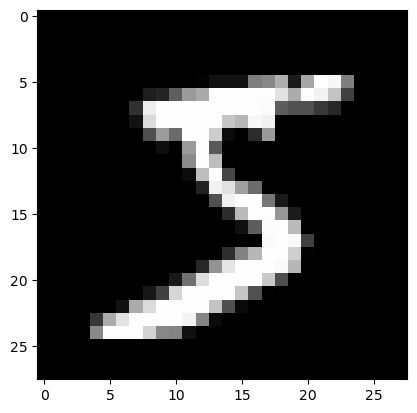

In [14]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

Python comes with a standard library “itertools” that makes it easier to work with iterators. 
Lets see one example, [islice](https://docs.python.org/3/library/itertools.html#itertools.islice).
`.islice(iterable, start, stop[, step])`
<sup><sub>Make an iterator that returns selected elements from the iterable. If start is non-zero, then elements from the iterable are skipped until start is reached. Afterward, elements are returned consecutively unless step is set higher than one which results in items being skipped. If stop is None, then iteration continues until the iterator is exhausted, if at all; otherwise, it stops at the specified position.</sub></sup>

In [15]:
from itertools import islice  

Lets create an iterator `it` and then call `next` a few times. 
We pass the 10 value list `vals` to `iter()` to turn `it` into an iterator.
We can call `next(it)`, it's giving us each item, one at a time.
That's what converting it into an iterator does. 

In [16]:
it = iter(vals)
for i in range(10): print(next(it))

0.0
0.0
0.0
0.19140625
0.9296875
0.98828125
0.98828125
0.98828125
0.98828125
0.98828125


`islice` converts `isit` into a different kind of iterator.   
It's now only returning the first five, before it raises `StopIteration`. 
`islice` grabs the first n things from an iterable (something that  you can iterate).   

In [17]:
it = iter(vals)
isit = islice(it, 5)

If we pass it to `list()` again this iterator 
has now grabbed the first five things,  so it's now up to thing number six.

In [18]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

If we call it again it's the next five things, 

In [19]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

and if we call it again, then there's nothing left.

In [20]:
list(islice(it, 5))

[]

In [21]:
def f(): return list(islice(it, 28))
it = iter(vals)
islice(it, 5)

In [22]:
f()

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

Now lets do the "chunks" with `islice`.
To `iter`  we can pass a list (to create an iterator) or we can pass it  a “callable”. 
A callable is something that we can put parentheses after, a function, a class, etc.
So we're going to pass it a function and, in the second form, 
it's going to be called until the function returns `[]`, empty list. 
And `islice` will return empty list when it's done.  
<br>
This is going to keep calling this function again and again, until it gets an empty list.  
So if we do it with 28 then we're going to get our image again. 

In [23]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

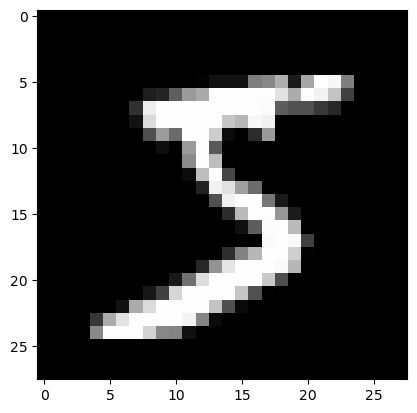

In [24]:
plt.imshow(img);

So we've now got two different  ways of creating exactly the same thing.  

### Playing with iterators

Now is a good time to play with iterators.
`lambda`s are as functions that we define them inline.
Let's replace the above `lambda` with a function `f()` and experiment.  So let's create our iterator, `it`.

In [25]:
def f(): return(list(islice(it, 28)), [])
it= iter(lst1)

then call `f()` on it, and it returns the first 28. 
And  each time I do it I'm getting another 28.  

In [26]:
f()    # call multiple times to get many values.

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [])

## Matrix and tensor

`img` is a list of lists, and each list is 28 long.
We can index into it, e.g., `img[20]`, is a list of 28 numbers. 

In [27]:
len(img[20])

28

We can index into it, `image[20][15]`, but for matrices, we would rather write it like `M[i, j]`.
For this, we have to define our own class.  

In [28]:
img[20][15]

0.98828125

To create a class in Python, we write “class”  and then write the name of it. 
Then we need to write "dunder" methods, with names of two \__ underscores, a special word, and then two \__ underscores, e.g.`__init__`.
These Dunder methods are special methods which have particular meanings to Python,
all documented in the [Python data model](https://docs.python.org/3/reference/datamodel.html).

We want to be  able to call `img[20,15]`. 
As part of the data model, there is `__getitem__`.  
When we call square brackets on an object that's what Python uses. 
And it's going to  pass across the `[20,15]` as indices `idxs`.  
So we `return self.xs[idxs[0]][idxs[1]]` , with the first index and the second index.   

In [29]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

So let's create that Matrix class and run that and check that `m[20,15]` is the same.  

In [30]:
%time
m = Matrix(img)
m[20,15]

CPU times: user 51 µs, sys: 14 µs, total: 65 µs
Wall time: 12.2 µs


0.98828125

### Tensor
Now that we've created something  that lets us index into things, 
we're allowed to use this one feature in Pytorch.   
To create a  tensor like our Matrix, we can now pass a list into `tensor()` 
to get back a tensor version of that list.

In [31]:
import torch
from torch import tensor

Pytorch documentation is not great.
So here's [tensor](https://pytorch.org/docs/stable/tensors.html). 
Tensors do just about everything for  numeric programming.  
It's worth scrolling through to get a general sense.
This is how we constructed one before, passing it list of lists. 
We can also pass it NumPy arrays, change types, etc.
Eventually we want to know about every single method,
or at least be aware of what  exists so we know what to search for in the docs.
Otherwise we end up recreating stuff from scratch, which is slower than reading the documentation to find out it's there.

In [32]:
tensor([1,2,3])

tensor([1, 2, 3])

More interestingly, we can pass in a list of lists, e.g., `img`.  

In [33]:
%time
tens = tensor(img)
tens[20,15]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


tensor(0.9883)

We've successfully reinvented that, so we can convert all our lists into tensors.
A convenient way is  Python's `map()` function, which takes a function `f` and one or more iterables, (in this case one iterable,) applies `f` (e.g., `tensor`) to the four `x_ , y_` variables, and returns 4 results.
It is converting these lists to tensors and storing them back with the same name.

In [34]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

`x_train` now is a tensor, so it has a `.shape` property: 
it has  50,000 images each 784 long. 
We can find out what kind of elements it contains by calling `.type()`. It contains floats. 

In [35]:
x_train.type()

'torch.FloatTensor'

Instead of chunks, or  islice, the `reshape` method is roughly equivalent in a tensor.
To reshape our 50,000 by 784 tensor into 50,000 28 by 28 tensors, we write `reshape(50,000, 28, 28)`.  
Or, we can use `-1` which means just fill this with all the rest, i.e., it can figure out that must be 50,000. 

In [36]:
imgs = x_train.reshape((-1,28,28))   #-1 means figure it out by yourself
imgs.shape

torch.Size([50000, 28, 28])

`imgs` is a batch of 50,000 28x28 images, and a rank-3 tensor in Pytorch. 
NumPy would call it an array with 3 dimensions.   
The rank is the number of dimensions. 
Each image is a matrix, a 28 by 28 rank-2 tensor.  
A vector is a rank-1 tensor, a scalar is a rank-0 tensor.
Many languages/libraries don't do it that way, so a scalar is dependent on the language.

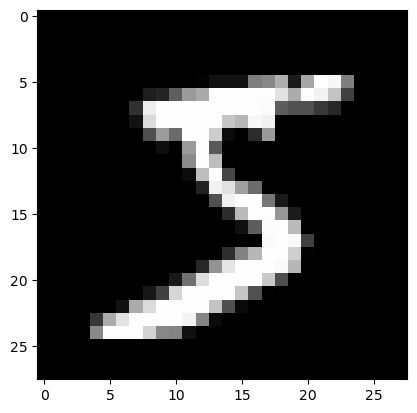

In [37]:
plt.imshow(imgs[0]);

We can index into the 0th image, 20th row, 15th column to get back this same number.  

In [38]:
imgs[0,20,15]

tensor(0.9883)

In [39]:
x_train.shape

torch.Size([50000, 784])

We can take `x_train.shape` and destructure it into `n`, number of images, `p`, the number of pixels. 

In [40]:
n,p = x_train.shape
n, p

(50000, 784)

`y_train` is going to be the labels, the digits.  Its `.shape` indicates there are 50,000 labels.

In [41]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

`min()` and `max()` are part of the library, so we can find out what are the smallest and largest number. 
They go from 0 to 9, and are scalar tensors. 

In [42]:
min(y_train),max(y_train)

(tensor(0), tensor(9))

In [43]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Random numbers
We're allowed to use random numbers, because there is a random number generator in the python standard library.
Still, we're going to do random numbers from scratch ourselves, because it's instructive.

A PRNG is a mathematical function that each time we call it returns a number that "looks" random,
that is. an even distribution of random numbers and that there's no obvious correlation from one to the other.
To illustrate this, lets call the Python library's `random()` 50 times and plot it.
For a random sequence we expect that there's no obvious relationship between one call and the next, so
the numbers would look quite different to each other.  

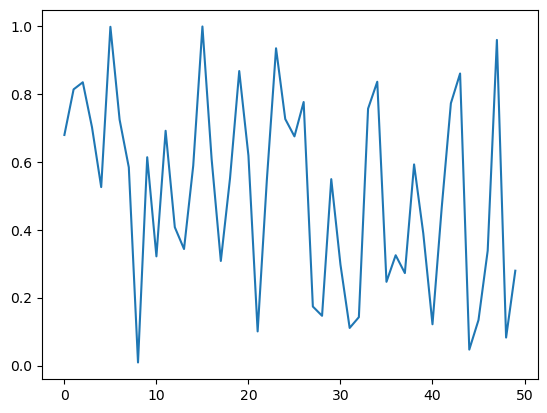

In [44]:
from random import random
plt.plot([random() for _ in range(50)]);

`random()` should return uniformly distributed random numbers.
If we call it lots of times and plot its histogram, we should see a fairly  evenly spread.

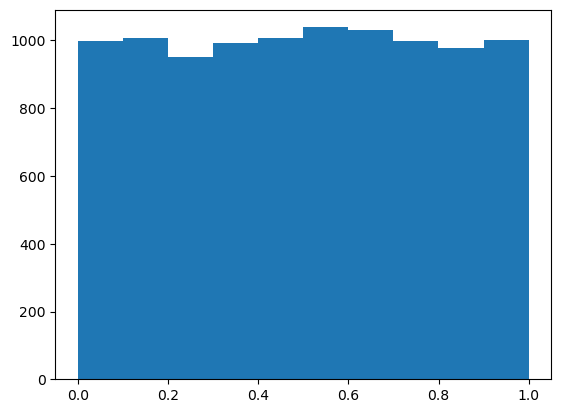

In [45]:
plt.hist([random() for _ in range(10000)]);

### Harware Random Number Generator

There is no way in pure software to create a random number. 
For that we need a [Hardware random number generator](https://en.wikipedia.org/wiki/Hardware_random_number_generator).
There are some services that provide such:
- The Australian National University quantum random number generator looks at the quantum fluctuations 
of a vacuum and provides an API which will return them.
- Cloudflare has a wall of "lava lamps" and uses the pixels of a camera looking at them to generate random numbers. 
- See also [drand](https://pypi.org/project/drand/).

### Intel chip version
(Some?) Intel chips have rdrand](https://pypi.org/project/rdrand/), which will return random numbers.

In [46]:
import rdrand
from rdrand import RdRandom, RdSeedom
r = RdRandom()
rs = RdSeedom()
r.getrandbytes(10), r.randint(1,1000)

(b'\x10\x1c\xfc3^\x96AE\xba3', 32)

### Quantumrandom
The [quantumrandom](https://pypi.org/project/quantumrandom/) project
provides tools for interacting with [The ANU Quantum Random Number Generator](qrng.anu.edu.au). 
It communicates with their JSON API and provides a qrandom command-line tool, a Python API, and a Linux /dev/qrandom character device.    

In [47]:
import quantumrandom

In [48]:
q = quantumrandom.get_data(array_length=3)
s = q[0]*q[1]*q[2]
s, q[0], q[1], q[2]

(8079239306010, 11171, 31890, 22679)

In [49]:
def get_HW_seed():
    q = quantumrandom.get_data(array_length=3)
    return (q[0]*q[1]*q[2])
get_HW_seed()

6817218971880

These remote services can be  slow, so they can get us one random number from time to time. 
But we want a way of getting lots of random numbers, so we use a 
[Pseudorandom number generator, PRNG](https://en.wikipedia.org/wiki/Pseudorandom_number_generator),
a mathematical function that each time we call it returns a number that "looks" random. 

### Reimplementing Python pseudo-random Random

There is a random in the standard library, but it is instructive to build it from scratch.<br>
Based on the [Wichmann Hill algorithm](https://en.wikipedia.org/wiki/Wichmann–Hill) that was used before Python 2.3.

We're going to create `rand()` a function that has the above properties. 
Random state `rnd_state` is a global variable of one or more numbers. 
We start with no random state at all, and define a function `seed()` that we're going to pass something to. 
We can just mash the keyboard to create this number, or get it
from a hardware generator, or the current tick count in nanoseconds.
In Python we often use the number 42.
There's various ways of getting some random starting point.
When we pass it into `seed()`, it's going to do a bunch of modular divisions, 
create a tuple of three things, and store them in this global state, `rnd_state`.

In [50]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [51]:
seed(get_HW_seed())
rnd_state

(28991, 20270, 250)

In [52]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

`rand()` returns (pseudo) random numbers. We pull out the random state at the start,  we do some math ops to it, 
and then we store new random state.
Each time we call it we get a different number, so this is a random number generator.
<mark>  remember that random number generators rely on this `rnd_state` state.</mark>

In [53]:
rand(),rand(),rand()

(0.21916455029644055, 0.11301183355101996, 0.4984583114483423)

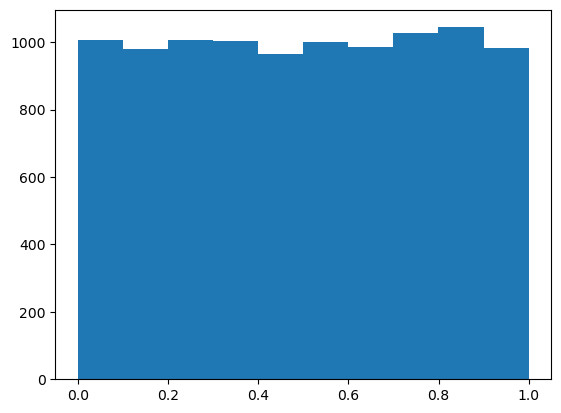

In [54]:
plt.hist([rand() for _ in range(10000)]);

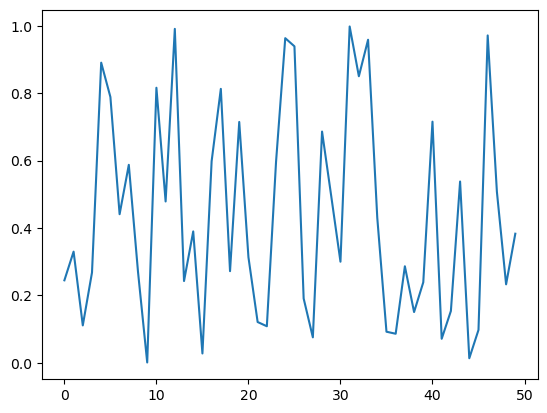

In [55]:
plt.plot([rand() for _ in range(50)]);

### Problem with initialization in Pytorch and Numpy

`os.fork()` creates a whole separate copy of a Python process. 
In one copy, the parent, `os.fork()` returns True, and on the other copy, the child, it returns `False`.
In each copy we call `rand()`, and expect to get 2 different random numbers. 
But they are the same number, because the processes are copies of each other,
and therefore, they each contain the same numbers in random state.  
In Deep Learning we often do parallel processing, for example, 
to generate lots of augmented images at the same time, using multiple processes.  
fastai used to have a bug where we failed to correctly initialize the random number generator separately, in each process.  

In [56]:
import os

In [57]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.7333976967462443
In child: 0.7333976967462443


To fix the above we need to reinitialize the seed with the HW seed.

In [58]:
if os.fork(): seed(get_HW_seed()), print(f'In parent: {rand()}')
else:
    seed(get_HW_seed())
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.46937376851486645


As of (Oct 2022), `torch.rand()` fails to initialize the random number generator. 
Pytorch does not re-initialize the random stream on the different processes :(

In [59]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.6272])
In child: tensor([0.6272])
In parent: tensor([0.6272])
In child: tensor([0.6272])


Numpy does not re-initialize the random stream  :(

In [60]:
import numpy as np
if os.fork(): print(f'In parent: {np.random.rand(1)}')
else:
    print(f'In child: {np.random.rand(1)}')
    os._exit(os.EX_OK)

In parent: [0.87456852]
In child: [0.87456852]


Python correctly re-initializes the random stream!

In [61]:
from random import random
if os.fork(): print(f'In parent: {random()}')
else:
    print(f'In child: {random()}')
    os._exit(os.EX_OK)

In parent: 0.7006995842086622
In child: 0.4217596970183204


#### Timeit
`%timeit` is a special IPython function that runs a piece of Python code this many times. 
It will do 7 runs and it'll take the mean and  standard deviation. 
Below we generate  random numbers, 7,840 times and put them into 10  
long chunks, and if I run that, it takes 4 milliseconds per loop. 

In [62]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.51 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Pytorch version is much faster!

In [63]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 8.26 times longer than the fastest. This could mean that an intermediate result is being cached.
82.7 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In the final layer of our neuralnet, where if we're doing a linear classifier, our linear weights need to be  784 by 10,
because that's the number of possible  outputs, the number of possible digits.
Below we create a 784 by 10 Matrix, `weights`, and assign it random numbers.
For the `bias`, we'll just use zeros to start with. The bias is just what we're going to add to each one. 

In [64]:
weights = torch.randn(784,10)
bias = torch.zeros(10)
weights, bias

(tensor([[-1.0348, -0.8211, -0.3084,  ...,  1.6865, -0.7853,  0.5059],
         [-1.5979,  0.2229,  1.8724,  ...,  0.2918,  0.3284,  0.5171],
         [ 0.5660, -1.5213,  1.3445,  ...,  0.7599, -0.8589, -1.8517],
         ...,
         [ 0.4097,  1.5504,  1.8820,  ..., -0.5139,  0.8419,  0.0546],
         [-1.9502, -0.2977, -0.5995,  ..., -0.5379,  0.5795, -2.7409],
         [ 0.0702, -1.3905,  0.5258,  ..., -0.1754, -0.3090, -0.4263]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Lets use a subset of MNIST, a matrix m1, which is just the first five digits. 

In [65]:
m1 = x_valid[:5]
m2 = weights

For matrix multiplication, we do a little minibatch, 5 rows of images flattened out,
and then multiply by this weights matrix. 

In [66]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

The shapes are: m1 is 5 by 784, m2 is 784 by 10. 
We deconstruct the shapes into variables `ar, ac, br, bc`.

In [67]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

The resultant tensor `t1` (where each item is the result from multiplying together the 
corresponding 784 pairs and adding them up), will be 5 by 10. 
`t1` starts with zeros. 

In [68]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

To fill `t1` we have to go  through each `ar` row one at a time, then through each `bc` column, one at a time,
and then through each pair in that row column one at a time. 
Its a loop in a loop in a loop. 
The result for that `i`irow and that `j` column, we add onto it the product of `i, k` in the  first matrix, 
by `k, j` in the second matrix. 
So `k ` is going up through those 784, across the rows and down the columns. 
This is a naive, slow, uninteresting matrix multiplication. 

In [69]:
%time
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 16 µs


In [70]:
t1.shape, type(t1)

(torch.Size([5, 10]), torch.Tensor)

In [71]:
t1

tensor([[ -2.2123,   2.1694,  -4.0014,  16.7547,   5.5465, -10.4748,  11.1194,
           3.5031,  -4.2439, -11.7703],
        [  8.7356,   7.8655,  -0.1184,  16.5655,   0.0430,   0.1153,   4.9983,
          -2.9498,  13.3753, -15.9750],
        [-12.6734, -12.6201,   4.6070,  16.3958,  -7.4134,  -2.2319,   0.8508,
          -2.7491,  -3.5166,  -9.2081],
        [ -8.7481,  10.5235,   1.9212,   7.1608,   4.0269, -17.4122,   6.6275,
          -0.5938,  15.9426, -11.2898],
        [ 12.1383,  -8.3448,  -3.0991,  18.8539,  -4.8022,  -8.5338,  -3.0787,
           3.3090,  -0.1900,  -2.7050]])

It's hard to read because it assumes/defaults the screens to 80 columns wide.
We change it with `set_print_options`, and choose line width 140. 
JH tends to always put these settings a at the top of notebooks, both for torch and NumPy. 

In [72]:
import numpy as np
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)   # make it easier to read
np.set_printoptions(precision=2, linewidth=140)
t1

tensor([[ -2.21,   2.17,  -4.00,  16.75,   5.55, -10.47,  11.12,   3.50,  -4.24, -11.77],
        [  8.74,   7.87,  -0.12,  16.57,   0.04,   0.12,   5.00,  -2.95,  13.38, -15.97],
        [-12.67, -12.62,   4.61,  16.40,  -7.41,  -2.23,   0.85,  -2.75,  -3.52,  -9.21],
        [ -8.75,  10.52,   1.92,   7.16,   4.03, -17.41,   6.63,  -0.59,  15.94, -11.29],
        [ 12.14,  -8.34,  -3.10,  18.85,  -4.80,  -8.53,  -3.08,   3.31,  -0.19,  -2.71]])

Check that the multiplication is correct, `@` does exactly  the same things we just did.  

In [73]:
s1 = m1 @ m2
s1.shape, type(s1)

(torch.Size([5, 10]), torch.Tensor)

We have successfully multiplied the matrices `m1` and `m2`. 

In [74]:
s1[0], t1[0]

(tensor([ -2.21,   2.17,  -4.00,  16.75,   5.55, -10.47,  11.12,   3.50,  -4.24, -11.77]),
 tensor([ -2.21,   2.17,  -4.00,  16.75,   5.55, -10.47,  11.12,   3.50,  -4.24, -11.77]))

We work step by step in Jupyter, and then once it is working, copy all the cells and paste them.
Select them  with shift+M to merge, get rid of prints that we don't need. 
Then add a header on the  top, give it a function name, and turn it into a function. 
We still keep the stuff above it, so we can see the step by step stuff for learning about it later.  

In [75]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    assert(ac==br)
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [76]:
ar*ac*bc # Total number of multiplications... how long it took?

39200

We can see how long it takes to run by using %time. 
And it took a long time to generate a small matrix, just five MNIST digits. 
We need to speed that up.

In [77]:
%time _=matmul(m1, m2) # half a second?

CPU times: user 465 ms, sys: 2.51 ms, total: 467 ms
Wall time: 467 ms


## Numba

Numba takes Python and compiles it into machine code, and also CUDA code.
We must enable the cuda simulator BEFORE loading numba

In [78]:
if not(torch.cuda.is_available()):
    import os
    os.environ['NUMBA_ENABLE_CUDASIM']='1'

In [79]:
from numba import njit

Just  write @njit above the function definition.
The first time we call the function it compiles it to machine code.
After it will run much more quickly. 

`dot` is just the inermost loop: start at zero, go through and add up all  those just for two vectors and return it. 
(a dot product in linear algebra).t. 

In [80]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

Numba only works with  NumPy, doesn't work with PyTorch.  

In [81]:
from numpy import array

Lets do a `dot` product of 1, 2, 3 and 2, 3, 4.
It took a long time, ms, because that's how long it took to compile and run it. 

In [82]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 331 ms, sys: 101 ms, total: 432 ms
Wall time: 810 ms


20.0

Now that it's compiled, the second time, it's just microseconds, as Numba makes Python run at C speed. 

In [83]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 17 µs, sys: 1e+03 ns, total: 18 µs
Wall time: 21.2 µs


20.0

If we replace the core loop in Python with a call to `dot`, (now running in machine code), then we have only 2 loops running "in Python". 

In [84]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [85]:
m1a,m2a = m1.numpy(),m2.numpy()

%timeit -n 10 matmul(m1a,m2a)

The slowest run took 22.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1.25 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
%time _ = matmul(m1a,m2a);

CPU times: user 1.34 ms, sys: 1.08 ms, total: 2.41 ms
Wall time: 1.58 ms


Now it is much times faster, just by changing the one innermost loop with an @njit compiled version.
Numba can make Python code very fast. 

In [87]:
from fastcore.test import test_close

We need to test the results are close.
`test_close()` comes from fastcore.test and it checks that 2 things are very close. 
They might not be exactly the same because of floating point differences. 
`matmul` is working correctly, or at  least it's doing the same thing it did before.  

In [88]:
test_close(t1,matmul(m1a, m2a),eps=1e-3)

## Elementwise ops

[TryAPL](https://tryapl.org/)

Many say that learning APL taught them more about programming than anything, so consider learning APL. 
We can do similar things in PyTorch but it is more verbose.
JH likes to do mathematical fiddling in APL, with less boilerplate, 
more time thinking, see everything on the screen at once.
No waste of time trying to ignore the Python cognitive load, 
e.g., tensor around bracket, square bracket, dot comma, etc.

In [89]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

We can say a + b and it works like in APL.

In [90]:
a + b

tensor([12., 14.,  3.])

The `<` operates element wise. 
`a < b` means: 10 is less than 2, 6 is less than 8, 4 is less than 7 and gives us back
each of those `True` and `False`. 

In [91]:
(a < b)

tensor([False,  True,  True])

`True` and `False` are represented by 1 and 0, so we can use them for math, e.g., we can add them and subtract them. 

In [92]:
(a < b).float().mean()

tensor(0.67)

Higher rank, `m` is a rank-2 tensor, a matrix.

In [93]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

We will use the **Frobenius** norm in generative modeling: 
Take all the elements of a matrix, square them, add them up and take the square root.  

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there. Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and the source includes the equations to copy and paste. This is the source LaTeX that renders the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In PyTorch is as follows:  

In [94]:
(m*m).sum().sqrt()   #Frobenius norm of m

tensor(16.88)

We index into a  matrix, rows first and then columns. 
`m[2,:]` means all the columns of row 2, and `m[:,-1]` are all the the rows of the last column.
We use `,` to print out multiple things, no need to say print in Jupyter, its assumed. 

In [95]:
m[2,:], m[:,-1]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

For tensors of higher rank than 1, such as a matrix, any trailing colons are optional. 
`m[2]` is the same as `m[2, :]`. 

In [96]:
m[2]

tensor([7., 8., 9.])

Now we can get rid of that innermost loop (`k`), as it is multiplying together 
all the corresponding columns of `a` with the  corresponding rows of a column of `b`. 
We can use element wise operation: `a[i,:] * b[:,j]`

In [97]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [98]:
test_close(t1,matmul(m1, m2))

In [99]:
%timeit -n 10 _=matmul(m1, m2)

799 µs ± 61.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We time it, and it is slower than the Numba complied code, but faster than our naive first attempt.
And we're using something that is  more general now, the same as `dot`.
Now we can use `torch.dot()`, which is a little faster, but still slower than the Numba.

In [100]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [101]:
test_close(t1,matmul(m1, m2),eps=1e-4)

In [102]:
%timeit -n 10 _=matmul(m1, m2)

637 µs ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [103]:
a

tensor([10.,  6., -4.])

In [104]:
a > 0

tensor([ True,  True, False])

How are we able to do `a > 0`?  `0` is being **broadcast** to have the same dimensions as `a`.
For instance we can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.
<br>
Other examples of broadcasting with a scalar:

In [105]:
a + 1

tensor([11.,  7., -3.])

In [106]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [107]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

Broadcasting a scalar dates back to APL, but the idea of broadcasting **across higher rank tensors** [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) the language [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector to a matrix:

In [108]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [109]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [110]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

Instead of broadcasting a scalar over a  higher rank tensor, this is broadcasting
a vector across every row of a matrix. 

In [111]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

And it works both ways, so `c + m` gives us the same thing. 

In [112]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

#### expand_as()
`expand_as(m)` creates a new thing `t`, with the same content as `c`, 
but expanded so it has the same shape as `m`. 
Here's what `t` looks like, it contains 3 copies of `c`. 

In [113]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

And we can definitely add t to m because they match shapes. 

In [114]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

`expand_as()` didn't  create three copies. 
`t.storage()` below tells us what is actually in memory, here just the numbers 10, 20, 30.  

In [115]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage._TypedStorage(dtype=torch.float32, device=cpu) of size 3]

But it has a stride of 0 across the  rows and a size of `[3, 3]`, so it acts as a 3 by 3 matrix. 
And each time it "goes" to the next row, it actually stays where it is. 
Strides is the trick which NumPy and PyTorch use to create efficient ways to do things
like expanding, jump over things, switch between columns and rows.
We didn't make a copy, it is efficient and it's going to run in C code fast.  
`expand_as()` is critical to understand how broadcasting works.

In [116]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

To convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1)
we can index with the special value `None` or use `unsqueeze()`. 
`c` is  a vector containing `[10, 20, 30]`, then `c.unsqueeze(0)`, changes the shape from `[3]` to `[1,3]`. 
From a vector of length 3 to a matrix of 1 row by 3 columns.
Notice it's printed, with two square brackets `[[ .... ]]`. 

In [117]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [118]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

`unsqueeze(1)` means to unsqueeze into the first dimension, i.e., we now have 3 rows and 1 column. 

In [119]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [120]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

We can do the same thing here, give us every row and a new unit axis in position 1.
`c[None]` creates a matrix with 1 row, and `c[...,None]` creates a matrix with 1 column.
We can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [121]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

Let's check out what `c[:, None]` looks like: it is a column. 

In [122]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

with `.expand_as(m)`, which is 3 by 3, it is going to take that column and replicate it. 

In [123]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

To add a matrix to m, we don't need to say `.expand_as()`, we just  write `m + c[:, None]`,
which does `.expand_as()` for us. 

In [124]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

Below is the same as doing `m + c`,  but now rather than adding the vector to each row, it's adding the vector to each column. 

In [125]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [126]:
c[None,:]

tensor([[10., 20., 30.]])

In [127]:
c[None,:].shape

torch.Size([1, 3])

In [128]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [129]:
c[:,None].shape

torch.Size([3, 1])

What are  the rules and how does it work?  `c[None, :]` is 1 by 3. `c[:, None]` is 3 by 1. 
If we do `c[None, :] *  c[:, None]` it's gonna to take the 10, 20, 30 column vector or 3 by 1 matrix, 
and it's gonna have to make it work across each of the rows. 
It expands it to be 10, 20, 30; 10, 20, 30; 10, 20, 30. 
And then it's gonna do the  same thing for `c[None, :]`, becomes three rows of 10, 20, 30. 
We have 3 rows of 10, 20, 30 times 3 columns of 10, 20, 30, which gives us the answer below. 
This is an **outer product**, without any special functions, just using broadcasting. 

In [130]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

We can do outer Boolean operations. 
Below is showing us all the places where  it's greater than, it's kind of an outer  Boolean. 

In [131]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

We can use this to speed up our matrix multiplication. 

Let's take single digit `m1[0]`  its shape is it's a 784 long vector, and the weight matrix is 784 by 10. 

In [132]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

`digit[:, None].shape` is a 784 by 1 row matrix.

In [133]:
digit[:,None].shape

torch.Size([784, 1])

If we take the `[784,1]` and `expand_as(m2)`, it's going  to be the same shape as our weight matrix `m2`. 

In [134]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

So it's copied our image data for that digit across all of the 10  vectors representing 
the 10 kind of linear  projections we're doing for our linear model. 
Now  we can take `digit[:, None]` and multiply it by the weights, to get us back a `[784,10]`. 
It is looping through  each of these 10 784 long vectors, and for each one of them, it's  multiplying it by this digit. 
That's what we want to do in our matrix multiplication. 

In [135]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [136]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [137]:
test_close(t1,matmul(m1, m2),eps=1e-4)

In [138]:
%timeit -n 10 _=matmul(m1, m2)

139 µs ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our time has gone from ~500ms to <0.1ms, an over 5000x improvement! We can run on the whole dataset now.

In [139]:
tr = matmul(x_train, weights)
tr

tensor([[ -7.55,  -2.45,  -7.95,  ...,  -8.00,   2.33, -15.42],
        [  0.76,  -7.40,  19.00,  ...,  17.76,  -0.87, -19.18],
        [ -4.21,  -0.47,   3.48,  ...,  12.49,  -0.40,  -6.83],
        ...,
        [  8.47,   5.35, -11.27,  ...,   9.27,  10.59, -11.05],
        [  0.65,   3.76,   3.46,  ...,   2.98,  16.84, -19.50],
        [  4.60,   8.21,   0.32,  ...,  -1.42,  19.24,  -4.58]])

In [140]:
tr.shape

torch.Size([50000, 10])

In [141]:
%time _=matmul(x_train, weights)

CPU times: user 1.81 s, sys: 29.4 ms, total: 1.84 s
Wall time: 842 ms


## Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

Einstein summation is a compact representation for products and sums, e.g., `torch.einsum('ik,kj->ij', a, b)`.
We are going to replicate our matrix product with an Einstein summation.
In `'ik,kj->ikj'` an arrow separates inputs (left) from outputs (right).
Inputs are separated by commas, eg, there are two inputs. 
Letters are names for the dimensions. 
The first input matrix we're multiplying by `i` rows and `k` columns, the second `k` rows and `j` columns. 
This will return a new rank-3 tensor with `i` faces, `k` rows, and `j` columns. 
The number of letters corresponds to the rank. 
We repeat letters between input arrays, e.g., `ik` and `kj`,  to indicate 
that values along those axes will be multiplied together.
Each item in each row will be multiplied by each item down each column to create the i by k by j output tensor. 

m1 is 5 by 784, m2 is 784 by 10, so i=5, k=784 and j=10. 

In [142]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

So if we do this torch.einsum,  we end up with a i by k by j: 5 by 784 by 10. 

In [143]:
mr = torch.einsum('ik,kj->ikj', m1, m2)

mr.shape

torch.Size([5, 784, 10])

The result contains the original 5 rows of m1, the original 10 columns of m2, and for the 784 dimension,
they're all multiplied together, because it's been copied between the two arguments to the einsum.

If we now sum up that over this dimension we get back the original matrix multiply result.  

With this Einstein summation version, we get back the same thing. 
Its taken each of these columns by rows, multiplied them together to get a 5 by 784 by 10, 
and then added up that 784 for each one, which is what matrix multiplication does. 

In [144]:
mr.sum(1)

tensor([[ -2.21,   2.17,  -4.00,  16.75,   5.55, -10.47,  11.12,   3.50,  -4.24, -11.77],
        [  8.74,   7.87,  -0.12,  16.57,   0.04,   0.12,   5.00,  -2.95,  13.38, -15.97],
        [-12.67, -12.62,   4.61,  16.40,  -7.41,  -2.23,   0.85,  -2.75,  -3.52,  -9.21],
        [ -8.75,  10.52,   1.92,   7.16,   4.03, -17.41,   6.63,  -0.59,  15.94, -11.29],
        [ 12.14,  -8.34,  -3.10,  18.85,  -4.80,  -8.53,  -3.08,   3.31,  -0.19,  -2.71]])

The second rule says that if we omit a letter from the output, those values will be summed. 
So if we remove this k, which gives us ik and kj goes to ij, so we've removed the k entirely, 
that means that sum happens automatically. 

In [145]:
torch.einsum('ik,kj->ij', m1, m2)     # automated the sum.

tensor([[ -2.21,   2.17,  -4.00,  16.75,   5.55, -10.47,  11.12,   3.50,  -4.24, -11.77],
        [  8.74,   7.87,  -0.12,  16.57,   0.04,   0.12,   5.00,  -2.95,  13.38, -15.97],
        [-12.67, -12.62,   4.61,  16.40,  -7.41,  -2.23,   0.85,  -2.75,  -3.52,  -9.21],
        [ -8.75,  10.52,   1.92,   7.16,   4.03, -17.41,   6.63,  -0.59,  15.94, -11.29],
        [ 12.14,  -8.34,  -3.10,  18.85,  -4.80,  -8.53,  -3.08,   3.31,  -0.19,  -2.71]])

Einstein summation notation takes some practice to get used to, but it's convenient,
effecient way of thinking about what's going on, and can simplify code.  
It doesn't have to be a sum, we don't have to omit any letters when just doing products. 
We now define our matmul using torch.einsum, check it with test_close that the original result is equal 
to this new matmul. 

In [146]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [147]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

The speed 15 milliseconds for the whole thing compared to 600 ms. 
Is faster than the very fast broadcasting approach.

In [148]:
%timeit -n 1 _=matmul(x_train, weights)   # much faster...

9.02 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [149]:
test_close(tr, x_train@weights, eps=1e-3)

In [150]:
%timeit -n 1 _=torch.matmul(x_train, weights)

10.3 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Parallel and CUDA
Let's go faster by using a GPU, which does lots of things in parallel. 
We tell the GPU what are the things we want to do in parallel, one at a time.  
We're going  to write in pure Python something that works like a GPU, 
except it won't be in parallel, so it won't be fast at all.
First we have to create a function that can calculate just one thing, 
even if many other things are happening at the same time, it won't interact with anything else.
For a matrix multiplication lets define something which just fills in a single item of the result, 
e.g., row zero, column zero.
We define a new matmul where we pass in the coordinates to fill in, and start by passing it (0, 0). 

In the call we get the e.g., (0, 0) coordinates. 
We destructure them into i and j, the row and the column. 
We make sure that i and j are inside the bounds of our output matrix `c`. 
And we start at zero and loop through all of the columns of `a` and all the rows of `b` for i and j, 
just like the innermost loop of our very first Python attempt.
And then at the end assign that into the corresponding `c` output entry. 
So it fills in one piece of the grid successfully. 

In [151]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

We'll pass it the matrices we want to  multiply, and a tensor `res` pre-filled with zeros for the results.
We call matmul for location (0, 0), passing the two matrices and `res`, and we get the answer in cell (0, 0).  

In [152]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-2.21,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00]])

We call this rows by columns times each time with a different grid, in parallel,
because none of the different locations interact with any other location. 
Something which can calculate a little piece of an output on a GPU is called a `kernel`.   
<br>
We define `launch_kernel()`, pass it the `kernel` function, 
how many rows and columns are in the output grid, and any arguments needed to calculate it.
In Python, `*args` says any additional arguments that you pass are going to be put into an array `args`. 
<br>
`launch_kernel` will to loop through the rows of `a`, and for each row of `a`, 
it'll loop through the columns of `b` and call the `kernel`, (e.g., `matmul`),
on that grid location passing in m1, m2, and res. 
`*args` is going to unpack those and pass them as 3 separate arguments. 

In [153]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

We call `launch_kernel(matmul, ar, bc, m1, m2, res)` with `ar` all the rows of `a`, 
`bc` all the columns of `b`, and then the `*args`: `m1`, the first matrix, `m2`, the second matrix, 
and `res`, another torch.zeros.
It fills in the exact same matrix. 

In [154]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[ -2.21,   2.17,  -4.00,  16.75,   5.55, -10.47,  11.12,   3.50,  -4.24, -11.77],
        [  8.74,   7.87,  -0.12,  16.57,   0.04,   0.12,   5.00,  -2.95,  13.38, -15.97],
        [-12.67, -12.62,   4.61,  16.40,  -7.41,  -2.23,   0.85,  -2.75,  -3.52,  -9.21],
        [ -8.75,  10.52,   1.92,   7.16,   4.03, -17.41,   6.63,  -0.59,  15.94, -11.29],
        [ 12.14,  -8.34,  -3.10,  18.85,  -4.80,  -8.53,  -3.08,   3.31,  -0.19,  -2.71]])

To do it in parallel, we have to use CUDA the platform and API for Nvidia GPUs. 
To program in CUDA from Python the easiest way is with the Numba compiler, which can produce CUDA code. 
But CUDA will only work on an NVIDIA GPU. Mac GPUs are starting to get a little support from machine learning libraries,  but it's taking quite a while. 

In a computer without an NVIDIA GPU, we could use the Numba simulator, enabled by setting the environment variable NUMBA_ENABLE_CUDASIM to 1 prior to importing Numba. 
<mark> Todo: check how to make the simulator work</mark>

In [155]:
from numba import cuda

Instead of `@njit` we write `@cuda.jit`, and it behaves a little bit differently.
The earlier (Python) `matmul` and the `@cuda.jit` `matmul` are similar. 
But instead of passing in the grid, we call `cuda.grid`, saying how many dimensions does the grid has. 
Numba does the unpack and passing it so we don't have to pass over the grid.
So it doesn't need the `grid`.  
The decorator indicates to compile that function into CUDA code. 

In [156]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp
    cuda.syncthreads()

We create our output tensor just like before, and use `map` `cuda.to_device` to copy the input and output tensors to the GPU.

In [157]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train, weights,r))

In [158]:
r.shape

(50000, 10)

CUDA has a concept of "blocks", TPB which is threads per block. 
No need to worry about it now, just copy this. 
It's going to call each grid item in parallel with a number of different processes.
This is just the code which turns the grid into blocks. 

In [159]:
import math
TPB = 16
#TPB = 2 # For simulation
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(25000, 5)

To call a function (eg `matmul`) that has @cuda.jit, we need to pass it 
in square brackets how many blocks per grid (`blockspergrid` from the previous cell) 
and how many threads per block in each of the two dimensions:
`matmul[blockspergrid, (TPB,TPB)]`.
And then pass in the 3 arguments to the function: a, b, and c. 
This will launch the kernel matmul on the GPU, and fill in `rg` on the GPU.
So we need to copy it back to the CPU, (the host), with `copy_to_host`. 
`test_close` shows us that the result is similar to our original result.  

In [160]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1.03)

All the  GPU stuff we look at only works on NVIDIA GPUs. 
Mac GPUs are gradually starting to get a little  bit of support from ML libraries.
but it's taking quite a while. 

NB: Obviously, the speed of the simulator is also much lower than that of a real device. It may be necessary to reduce the size of input data and the size of the CUDA grid in order to make debugging with the simulator tractable.

In [ ]:
%%timeit -n 1
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

In a GPU is about 4 milliseconds, the PyTorch matmul on CPU was 15 milliseconds. 
We can actually go faster than that using the exact same code we had from the PyTorch up. 
But we take the tensors and write .cuda() after them so they are copied to the GPU.

In [ ]:
m1c,m2c = x_train.cuda(),weights.cuda()

And then copy back to the host with .cpu().
These are our two CUDA versions.
Now the whole thing will  run on the GPU. 

In [ ]:
%timeit -n 1 r==(m1c@m2c).cpu()

Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!